<a href="https://colab.research.google.com/github/lynxoo/ue-wroc-sad/blob/master/SAD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Statystyczna Analiza Danych
## Analiza Szkockich Whisky

Autorzy projektu:
* Łukasz Fąfara
* Artur Malarz

Oceny Whisky na podstawie smaku!  
95-100 points—Classic: a great whisky  
90-94 points—Outstanding: a whisky of superior character and style  
85-89 points—Very good: a whisky with special qualities  
80-84 points—Good: a solid, well-made whisky  
75-79—Mediocre: a drinkable whisky that may have minor flaws  
50-74—Not recommended  

## Wstęp

Celem projektu jest przeprowadzenie klasteryzacji oraz analizy wybranych danych statystycznych. Przedmiotem badań poniższej analizy będzie zbiór ocen szkockiej whisky pozyskany z serwisu [Keggle](https://www.kaggle.com/koki25ando/22000-scotch-whisky-reviews) \(serwis danych źródłowych [Whisky Advocate](http://whiskyadvocate.com/)).

Zbiór zawiera następujące informacje na temat produktu:
- numer porządkowy
- nazwę
- kategorię
- średnią ocen jakości whisky (smaku) wystawioną przez recenzentów
- cenę jednostkową
- opis

Większość rekordów zawiera także informacje na temat wieku danej whisky (czasu leżakowania) oraz zawartości alkoholu.

Dokonując analizy statystycznej zebranych danych, chcielibyśmy sprawdzić, czy whisky dostępne na rynku można skategoryzować względem jakości, ceny oraz zawartości alkoholu. Chcielibyśmy sprawdzić, które z tych parametrów mają na siebie wpływ, a także czy wiek whisky jest jego największą zaletą, która jednogłośnie dyktuje jego smak oraz cenę.

### Wstępna obróbka danych

W tym etapie dane zostaną wczytane, pozbawione nieistotnych kolumn, a te które pozostaną, zostaną poddane korekcji typu. Przy wykorzystaniu kolumny `name` zostaną wyodrębnione kolumny takie jak `abv`, mówiąca o zawartości alkoholu oraz `age` zawierająca czas leżakowania danego trunku.

In [0]:
import pandas as pd
scotch = pd.read_csv(r'https://github.com/lynxoo/ue-wroc-sad/raw/master/scotch_review.csv')

In [40]:
scotch.head(5)

,Unnamed: 0,name,category,review.point,price,currency,description
0,1,"Johnnie Walker Blue Label, 40%",Blended Scotch Whisky,97,225,$,"Magnificently powerful and intense. Caramels, ..."
1,2,"Black Bowmore, 1964 vintage, 42 year old, 40.5%",Single Malt Scotch,97,4500.00,$,What impresses me most is how this whisky evol...
2,3,"Bowmore 46 year old (distilled 1964), 42.9%",Single Malt Scotch,97,13500.00,$,There have been some legendary Bowmores from t...
3,4,"Compass Box The General, 53.4%",Blended Malt Scotch Whisky,96,325,$,With a name inspired by a 1926 Buster Keaton m...
4,5,"Chivas Regal Ultis, 40%",Blended Malt Scotch Whisky,96,160,$,"Captivating, enticing, and wonderfully charmin..."


#### Usunięcie nadmiarowych kolumn

Nienazwana kolumna z numerem porządkowym (`Unnamed: 0`) oraz opisem (`description`) są nieistotne na potrzeby poniższej analizy. Cena każdego z produktów została podana w dolarach, więc konwersja waluty jest niepotrzebna a sama jej kolumna (`currency`) może zostać usunięta. 

In [41]:
scotch.drop(['Unnamed: 0', 'currency', 'description'], axis=1, inplace=True)
scotch.head(5)

,name,category,review.point,price
0,"Johnnie Walker Blue Label, 40%",Blended Scotch Whisky,97,225
1,"Black Bowmore, 1964 vintage, 42 year old, 40.5%",Single Malt Scotch,97,4500.00
2,"Bowmore 46 year old (distilled 1964), 42.9%",Single Malt Scotch,97,13500.00
3,"Compass Box The General, 53.4%",Blended Malt Scotch Whisky,96,325
4,"Chivas Regal Ultis, 40%",Blended Malt Scotch Whisky,96,160


In [42]:
scotch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2247 entries, 0 to 2246
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   name          2247 non-null   object
 1   category      2247 non-null   object
 2   review.point  2247 non-null   int64 
 3   price         2247 non-null   object
dtypes: int64(1), object(3)
memory usage: 70.3+ KB


#### Korekcja typu kolumny `price`

W poniższym kroku obróbce poddana zostanie kolumna dotycząca ceny produktu.

In [43]:
def parse_price(text):
  try:
    return float(text)
  except:
    pass
  return None
scotch['price'] = [parse_price(price) for price in scotch['price']]
scotch['price'].isnull().value_counts()

False    2228
True       19
Name: price, dtype: int64

In [44]:
scotch.dropna(inplace=True)
scotch.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2228 entries, 0 to 2246
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          2228 non-null   object 
 1   category      2228 non-null   object 
 2   review.point  2228 non-null   int64  
 3   price         2228 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 87.0+ KB


Parsowanie wieku

In [45]:
scotch_age_test = scotch.copy()

import re
def parse_age(text):
  matches = re.search('(\d+) years? old', text, re.IGNORECASE)
  return int(matches.group(1)) if matches else None

scotch_age_test['age'] = [parse_age(text_age) for text_age in scotch_age_test['name']]
scotch_age_test.isnull().sum()

name               0
category           0
review.point       0
price              0
age             1028
dtype: int64

In [46]:
scotch_age_test[scotch_age_test['age'].isnull()]

,name,category,review.point,price,age
0,"Johnnie Walker Blue Label, 40%",Blended Scotch Whisky,97,225.0,NaN
3,"Compass Box The General, 53.4%",Blended Malt Scotch Whisky,96,325.0,NaN
4,"Chivas Regal Ultis, 40%",Blended Malt Scotch Whisky,96,160.0,NaN
5,"Ardbeg Corryvreckan, 57.1%",Single Malt Scotch,96,85.0,NaN
6,"Gold Bowmore, 1964 vintage, 42.4%",Single Malt Scotch,96,6250.0,NaN
...,...,...,...,...,...
2231,"MacNaMara Blended, 40%",Blended Scotch Whisky,76,35.0,NaN
2232,"Robert Burns Single Malt, 40%",Single Malt Scotch,75,40.0,NaN
2235,"Benromach Organic, 43%",Single Malt Scotch,74,75.0,NaN
2239,"Benromach Origins, Batch #1, 1999 vintage, 50%",Single Malt Scotch,72,85.0,NaN


In [0]:
scotch_age_test.dropna(inplace=True)

Parsowanie zawartości alkoholu

In [48]:
scotch_abv_test = scotch_age_test.copy()

import re
def parse_alcohol(text):
  matches = re.search(r"([\d.]+)%", str(text))
  return float(matches.group(1)) if matches else None

scotch_abv_test['abv'] = [parse_alcohol(name) for name in scotch_abv_test['name']]
scotch_abv_test.isnull().sum()

name            0
category        0
review.point    0
price           0
age             0
abv             7
dtype: int64

In [49]:
scotch_abv_test[scotch_abv_test['abv'].isnull()]

,name,category,review.point,price,age,abv
93,"Balvenie 1973 Vintage, 30 year old, Cask #9219",Single Malt Scotch,93,400.0,30.0,NaN
984,"Cask & Thistle (distilled at Aberfeldy), 29 ye...",Single Malt Scotch,87,110.0,29.0,NaN
1002,"Wild Scotsman (distilled at Ben Nevis), 13 yea...",Single Malt Scotch,87,70.0,13.0,NaN
1504,Duncan Taylor NC2 (distilled at Imperial) 1997...,Single Malt Scotch,85,60.0,13.0,NaN
1647,"Bruichladdich Full Strength, 1989 vintage, 13 ...",Single Malt Scotch,84,90.0,13.0,NaN
1956,"Gordon & MacPhail (distilled at Glenlossie), 2...",Single Malt Scotch,82,90.0,27.0,NaN
2034,Berry Brothers & Rudd (distilled at Cragganmor...,Single Malt Scotch,81,93.0,14.0,NaN


In [50]:
scotch_abv_test.dropna(inplace=True)
scotch_abv_test.isnull().sum()

name            0
category        0
review.point    0
price           0
age             0
abv             0
dtype: int64

Weryfikacja danych


In [51]:
scotch_abv_test['abv'].describe()

count    1193.000000
mean       48.027150
std         5.954231
min        40.000000
25%        43.000000
50%        46.000000
75%        52.700000
max        67.400000
Name: abv, dtype: float64

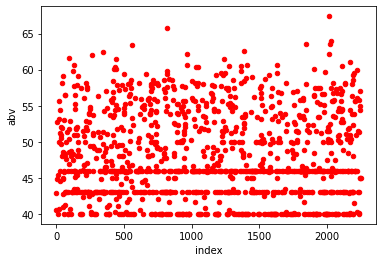

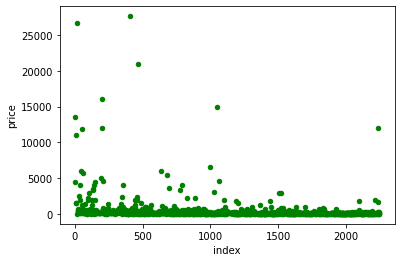

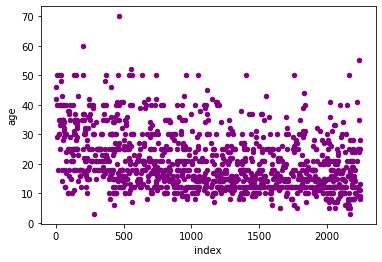

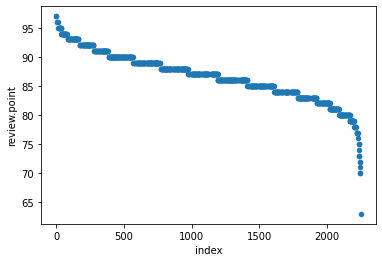

In [52]:
scotch_abv_test.reset_index().plot.scatter(x='index', y='abv', color='red')
scotch_abv_test.reset_index().plot.scatter(x='index', y='price', color='green')
scotch_abv_test.reset_index().plot.scatter(x='index', y='age', color='purple')
scotch_abv_test.reset_index().plot.scatter(x='index', y='review.point')

Usuwamy odstające dane

In [53]:
q1 = scotch_abv_test.quantile(0.25)
q3 = scotch_abv_test.quantile(0.75)
 
iqr = q3 - q1
iqr

review.point      6.0
price           150.0
age              13.0
abv               9.7
dtype: float64

In [54]:
outliers = (scotch_abv_test < (q1 - 4.0 * iqr)) | (scotch_abv_test > (q3 + 4.0 * iqr))
outliers.sum()

abv              0
age              0
category         0
name             0
price           79
review.point     0
dtype: int64

In [55]:
scotch_abv_test[outliers.any(1)]

,name,category,review.point,price,age,abv
1,"Black Bowmore, 1964 vintage, 42 year old, 40.5%",Single Malt Scotch,97,4500.0,42.0,40.5
2,"Bowmore 46 year old (distilled 1964), 42.9%",Single Malt Scotch,97,13500.0,46.0,42.9
7,"Bowmore, 40 year old, 44.8%",Single Malt Scotch,96,11000.0,40.0,44.8
8,"The Dalmore, 50 year old, 52.8%",Single Malt Scotch,96,1500.0,50.0,52.8
11,"Macallan 1976 Vintage, 29 year old, cask #1135...",Single Malt Scotch,96,1500.0,29.0,45.4
...,...,...,...,...,...,...
1831,"Glenglassaugh, 44 year old, 1960 vintage, 41.7%",Single Malt Scotch,83,900.0,44.0,41.7
2094,"BenRiach 40 year old, 50%",Single Malt Scotch,80,1800.0,40.0,50.0
2218,"Auchentoshan 1962, 41 year old, 40.3%",Single Malt Scotch,77,2000.0,41.0,40.3
2236,"The Macallan Lalique Decanter, 55 year old, 40.1%",Single Malt Scotch,74,12000.0,55.0,40.1


In [0]:
# scotch_abv_test.reset_index().plot.scatter(x='index', y='abv', c={"b": outliers.any(1), "r": ~outliers.any(1)})

In [57]:
no_outliers = ~(outliers).any(axis=1)

scotch_abv_test._update_inplace(scotch_abv_test[no_outliers])
scotch_abv_test.describe()

,review.point,price,age,abv
count,1114.000000,1114.000000,1114.000000,1114.000000
mean,86.395871,162.806104,19.412926,48.052145
std,4.063780,145.558497,8.533326,5.999513
min,63.000000,13.000000,3.000000,40.000000
25%,84.000000,70.000000,12.000000,43.000000
50%,87.000000,111.000000,18.000000,46.000000
75%,89.000000,190.000000,25.000000,52.875000
max,95.000000,824.000000,50.000000,67.400000


In [0]:
scotch_data = scotch_abv_test.copy()

## Rozkład wartości

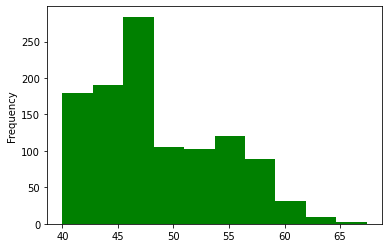

In [59]:
scotch_data['abv'].plot.hist(color='green')

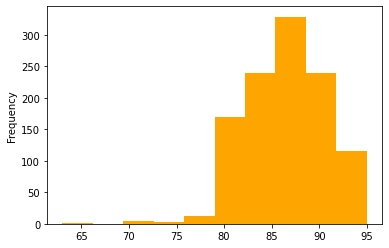

In [60]:
scotch_data['review.point'].plot.hist(color='orange')

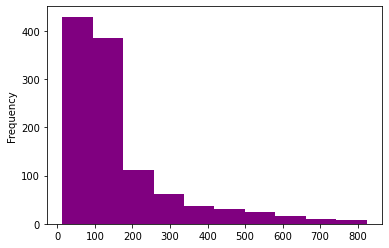

In [61]:
scotch_data['price'].plot.hist(color='purple')

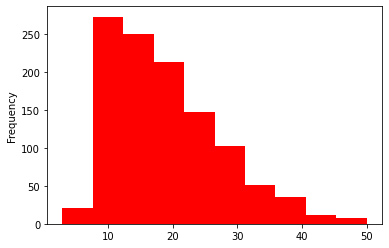

In [62]:
scotch_data['age'].plot.hist(color='red')

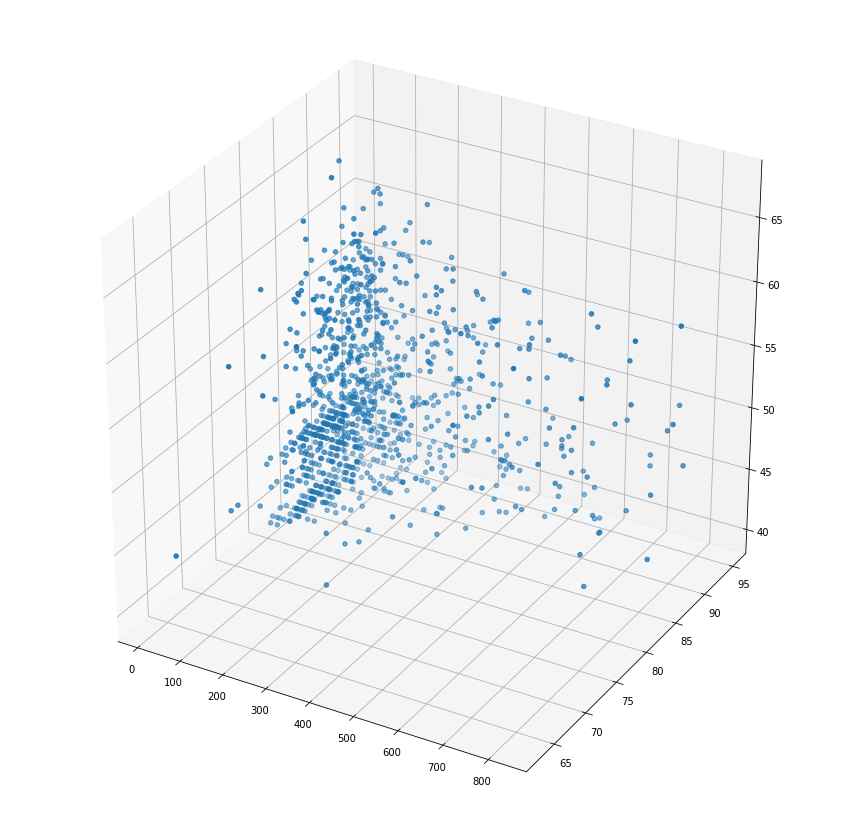

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

threedee = plt.figure(figsize=(15,15)).gca(projection='3d')
threedee.scatter(scotch_data['price'], scotch_data['review.point'], scotch_data['abv'])
plt.show()

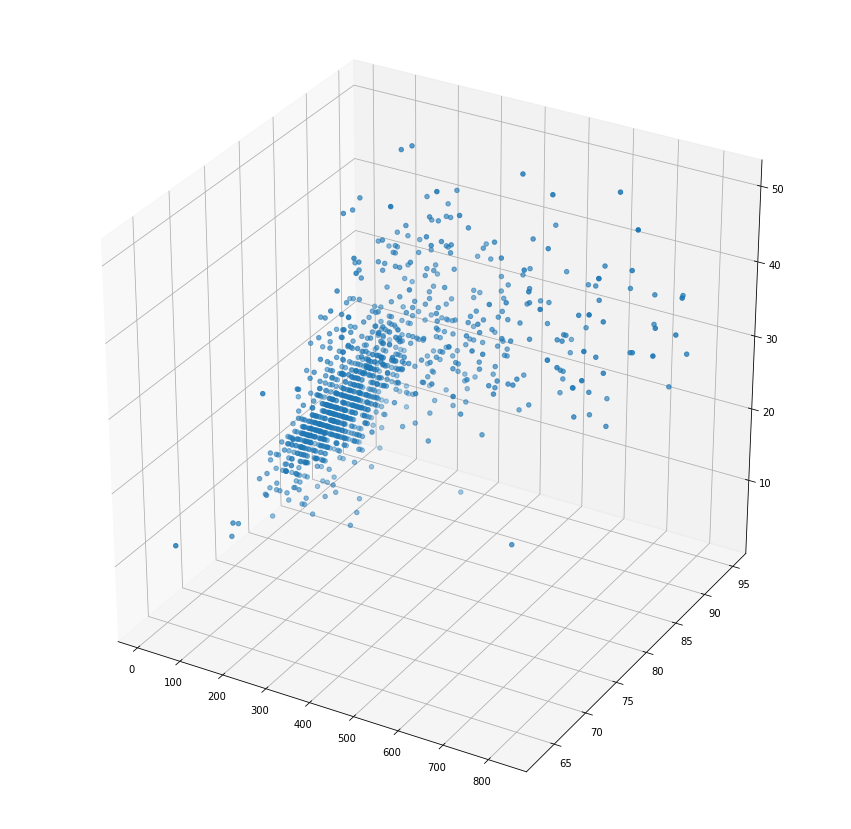

In [64]:
threedee = plt.figure(figsize=(15,15)).gca(projection='3d')
threedee.scatter(scotch_data['price'], scotch_data['review.point'], scotch_data['age'])
plt.show()

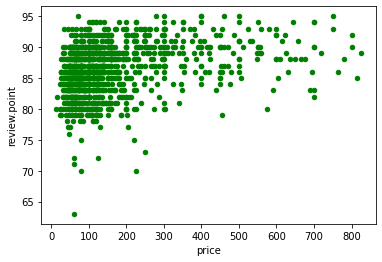

In [65]:
scotch_data.plot.scatter(x='price', y='review.point', color='green')

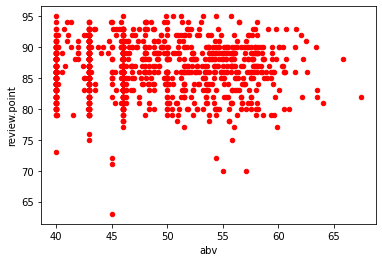

In [66]:
scotch_data.plot.scatter(x='abv', y='review.point', color='red')

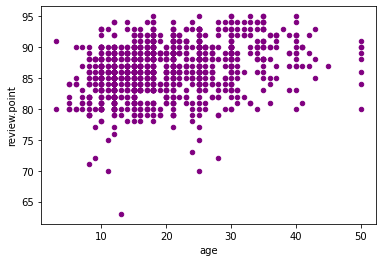

In [67]:
scotch_data.plot.scatter(x='age', y='review.point', color='purple')

Macierz korelacji

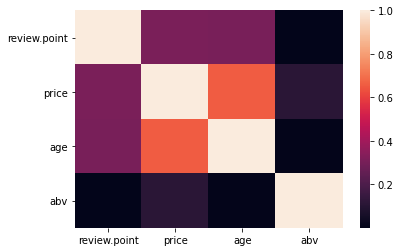

In [68]:
correlations = scotch_data.corr()

import seaborn as sns
sns.heatmap(correlations, 
        xticklabels=correlations.columns,
        yticklabels=correlations.columns)

In [69]:
# Czy to ma sens???
from enum import Enum
classes_numeric = Enum('WhiskyClass', list(scotch_data['category'].unique()), module=__name__)
classes_numeric

<enum 'WhiskyClass'>

In [70]:
scotch_data['class_numeric_label'] = [classes_numeric[category].value for category in scotch_data['category']]
scotch_data.corr()

,review.point,price,age,abv,class_numeric_label
review.point,1.000000,0.310375,0.306868,0.000833,-0.074235
price,0.310375,1.000000,0.658313,0.111333,0.054914
age,0.306868,0.658313,1.000000,0.007338,0.195407
abv,0.000833,0.111333,0.007338,1.000000,0.196580
class_numeric_label,-0.074235,0.054914,0.195407,0.196580,1.000000


## Klastrowanie

### K-Means Clustering

Kopia danych do przygotowania klastrowania

In [71]:

clustering_data = scotch_data[['age', 'price', 'review.point']].copy()
clustering_data.head(5)

,age,price,review.point
16,18.0,70.0,95
21,30.0,400.0,95
23,30.0,400.0,95
25,35.0,750.0,95
27,40.0,460.0,95


standaryzacja danych przy pomocy scalera (`StandardScaler`) z biblioteki `sklearn`, który odejmuje od każdej zmiennej średnią i dzieli ją przez odchylenie standardowe.

In [0]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# clustering_data[clustering_data.columns] = scaler.fit_transform(clustering_data)
# clustering_data.head(5)

2 klastry

In [0]:
from sklearn.cluster import KMeans
from sklearn import metrics
import numpy as np

inertia_scores = []
silhouette_scores = []
callinski_harabas = []
sample_clusters = np.arange(2, 12)
for n_clusters in sample_clusters:
  kmeans = KMeans(n_clusters=n_clusters).fit(clustering_data)
  inertia_scores.append(kmeans.inertia_)
  silhouette_scores.append(metrics.silhouette_score(clustering_data, kmeans.labels_))
  callinski_harabas.append(metrics.calinski_harabasz_score(clustering_data, kmeans.labels_))

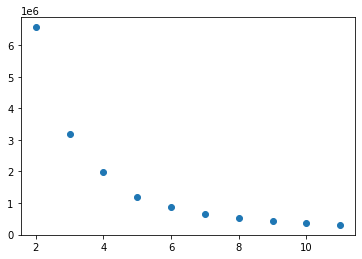

In [74]:
plt.scatter(x=sample_clusters, y=inertia_scores)

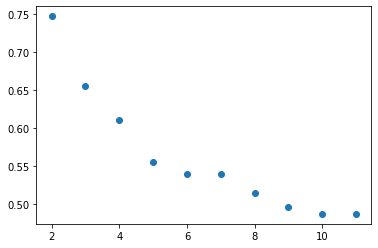

In [75]:
plt.scatter(x=sample_clusters, y=silhouette_scores)

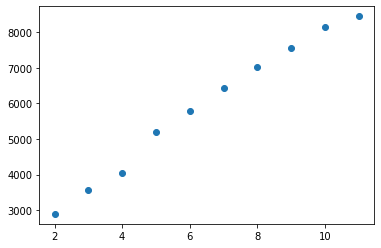

In [76]:
plt.scatter(x=sample_clusters, y=callinski_harabas)

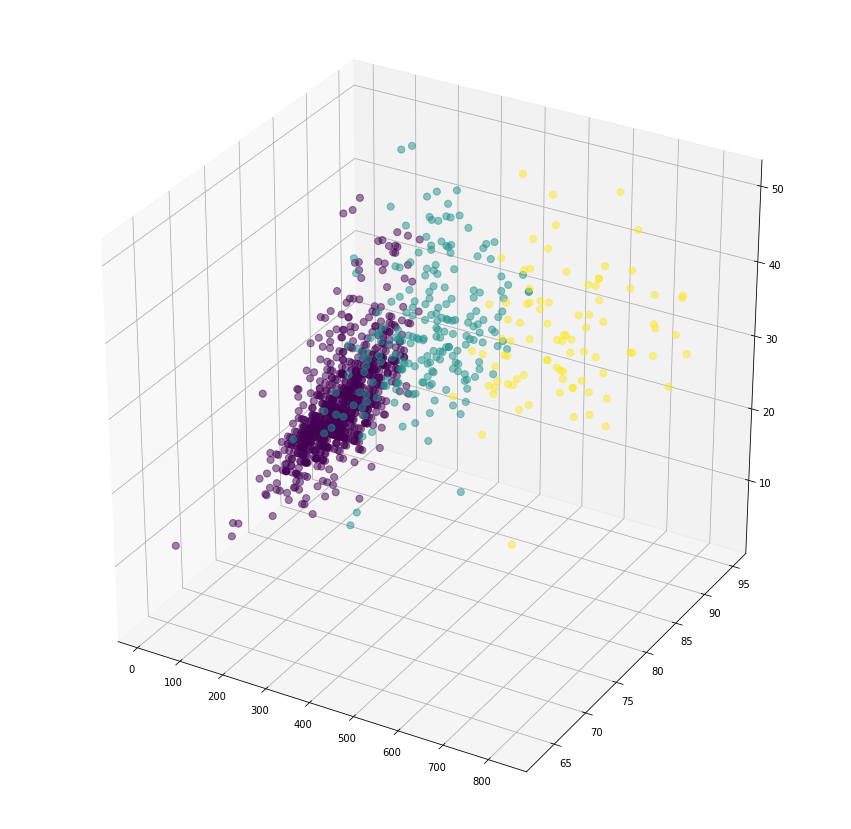

In [91]:
kmeans = KMeans(n_clusters=3).fit(clustering_data)
threedee = plt.figure(figsize=(15,15)).gca(projection='3d')
threedee.scatter(scotch_data['price'], scotch_data['review.point'], scotch_data['age'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.show()


## Agglomerative Clustering

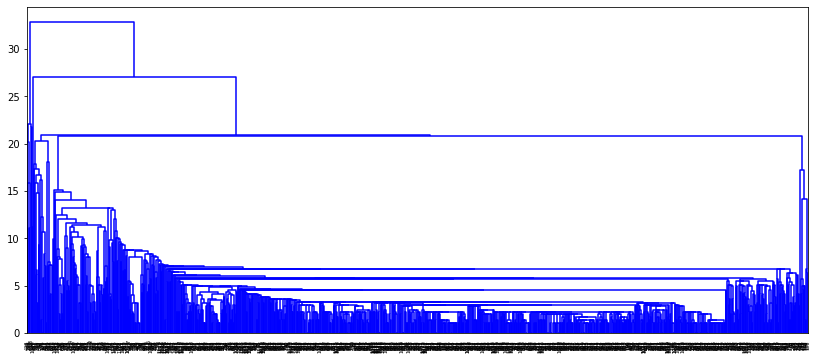

In [78]:
from scipy.cluster.hierarchy import dendrogram,linkage,fcluster

linkage_matrix=linkage(clustering_data,'single')
plt.figure(figsize=(14,6))
dendrogram(linkage_matrix,color_threshold=0)
plt.show()

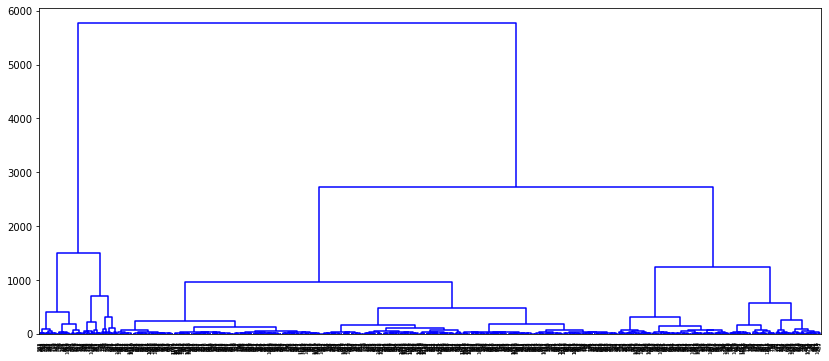

In [79]:
linkage_matrix=linkage(clustering_data,'ward')
plt.figure(figsize=(14,6))
dendrogram(linkage_matrix,color_threshold=0)
plt.show()

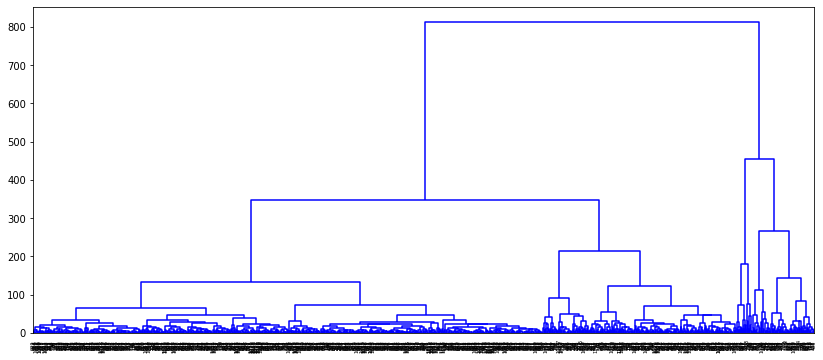

In [80]:
linkage_matrix=linkage(clustering_data,'complete')
plt.figure(figsize=(14,6))
dendrogram(linkage_matrix,color_threshold=0)
plt.show()

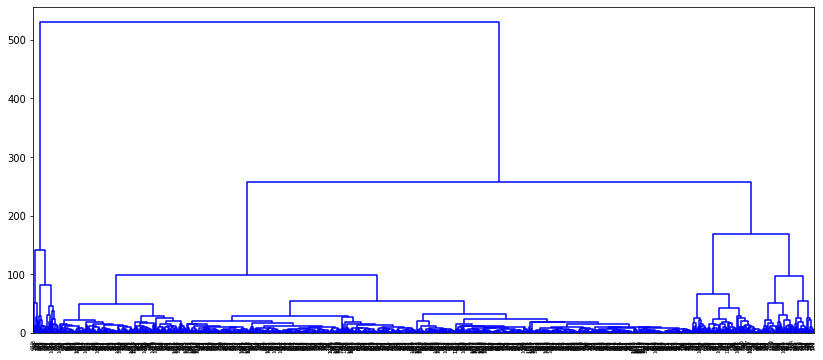

In [81]:
linkage_matrix=linkage(clustering_data,'average')
plt.figure(figsize=(14,6))
dendrogram(linkage_matrix,color_threshold=0)
plt.show()

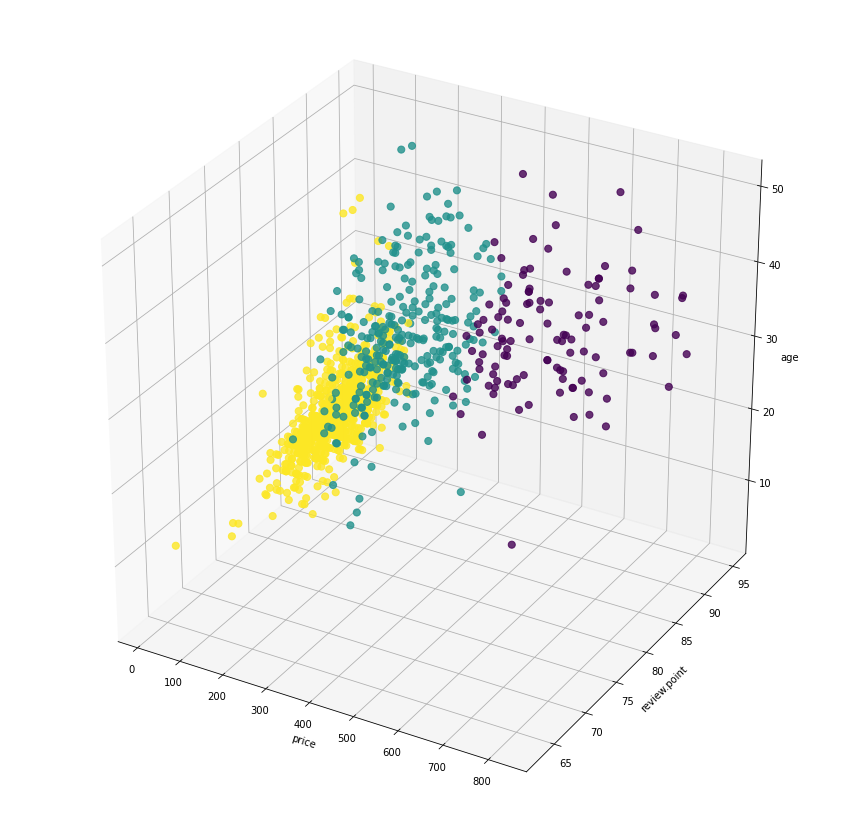

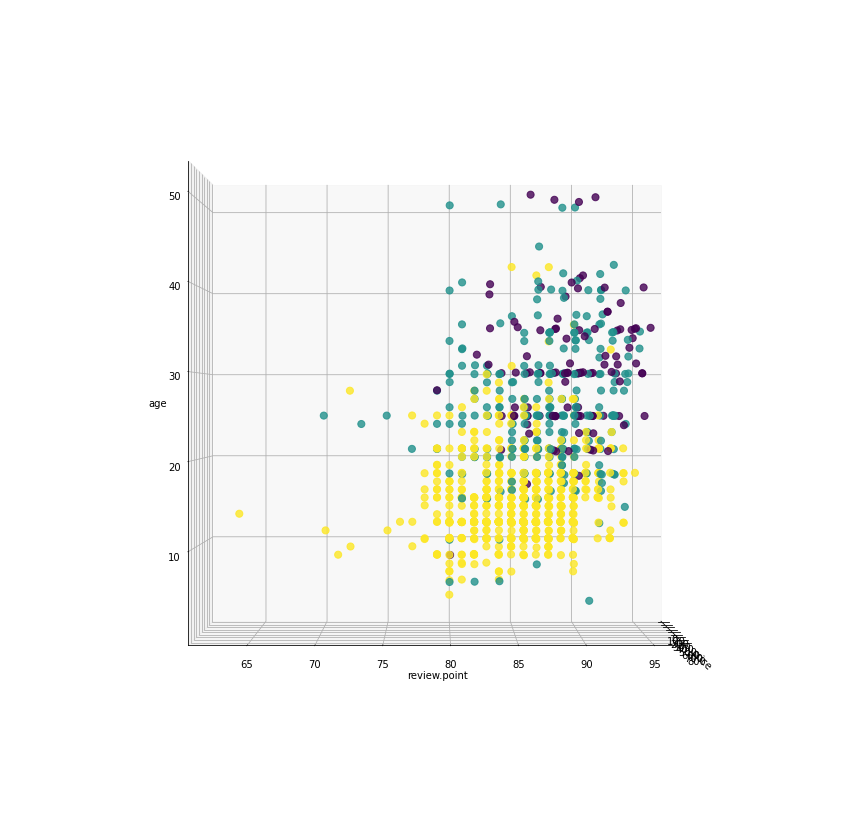

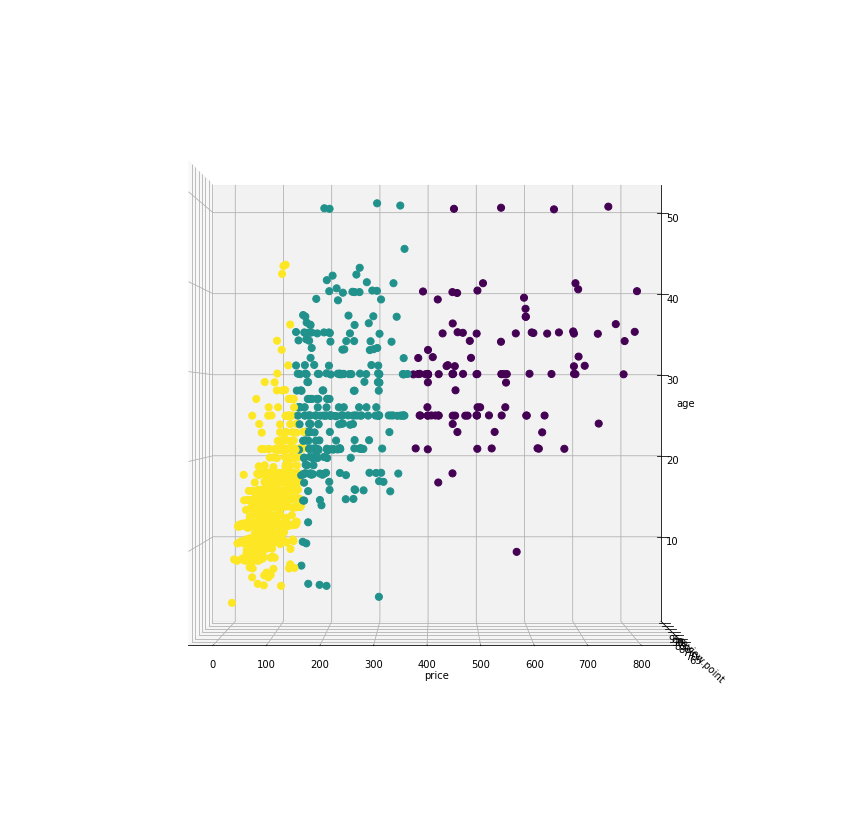

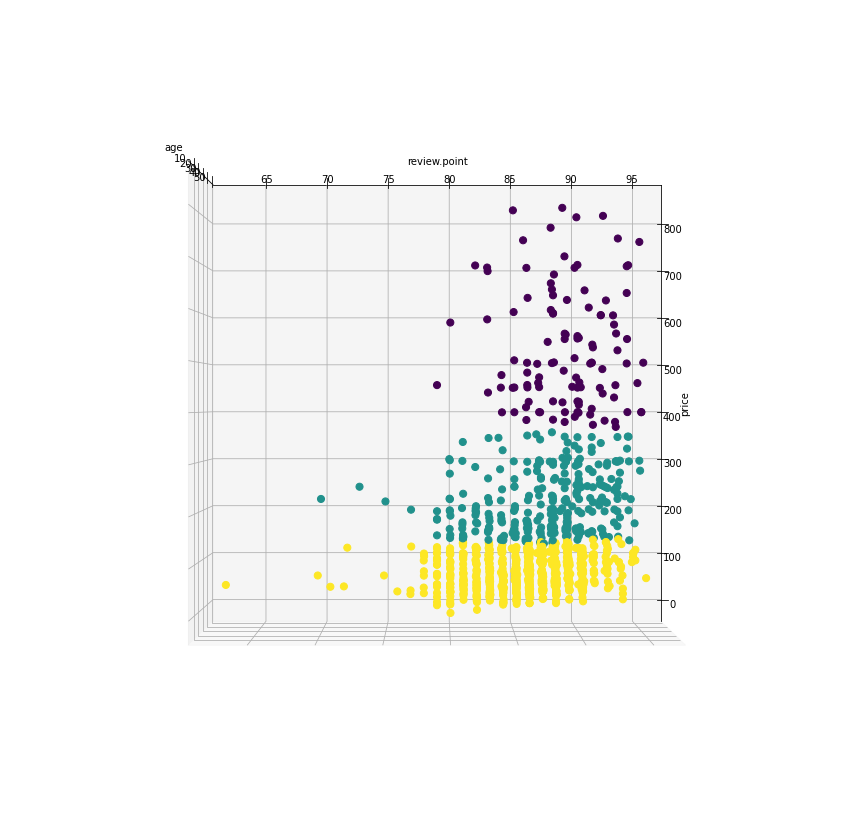

In [90]:

hc = AgglomerativeClustering(n_clusters=3).fit(clustering_data)
threedee = plt.figure(figsize=(15,15)).gca(projection='3d')
threedee.set_xlabel("price")
threedee.set_ylabel("review.point")
threedee.set_zlabel("age")
# threedee.view_init(15, -45)
threedee.scatter(scotch_data['price'], scotch_data['review.point'], scotch_data['age'], c=hc.labels_.astype(float), s=50, alpha=.8)

threedee = plt.figure(figsize=(15,15)).gca(projection='3d')

threedee.set_xlabel("price")
threedee.set_ylabel("review.point")
threedee.set_zlabel("age")
threedee.view_init(0, 00)
threedee.scatter(scotch_data['price'], scotch_data['review.point'], scotch_data['age'], c=hc.labels_.astype(float), s=50, alpha=.8)

threedee = plt.figure(figsize=(15,15)).gca(projection='3d')
threedee.set_xlabel("price")
threedee.set_ylabel("review.point")
threedee.set_zlabel("age")
threedee.view_init(0, -90)
threedee.scatter(scotch_data['price'], scotch_data['review.point'], scotch_data['age'], c=hc.labels_.astype(float), s=50, alpha=1)
plt.show()

threedee = plt.figure(figsize=(15,15)).gca(projection='3d')
threedee.set_xlabel("price")
threedee.set_ylabel("review.point")
threedee.set_zlabel("age")
threedee.view_init(-90, 0)
threedee.scatter(scotch_data['price'], scotch_data['review.point'], scotch_data['age'], c=hc.labels_.astype(float), s=50, alpha=1)
plt.show()

In [84]:
linkage_matrix=linkage(clustering_data,'ward')
class_number=fcluster(linkage_matrix,t=3,criterion='maxclust')
centers_new=clustering_data.groupby(class_number).mean()
centers_new_df=pd.DataFrame(centers_new)
centers_new_df.columns=clustering_data.columns
centers_new_df

,age,price,review.point
1,30.405405,529.819820,89.126126
2,15.005594,83.709091,85.538462
3,26.118056,217.722222,87.472222
